# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from collections import defaultdict
from tqdm import tqdm

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data

In [2]:
df = pd.read_csv("../files/data/Corner_Crack_CS4/Small_Cracks_Straight_Shank.csv", index_col=False)
df = df[df['a/t'] > 0.05]

# THIS IS NOISY
df_ = pd.read_csv("../files/data/Corner_Crack_CS4/20230926_CountersunkHoles_CS-2023-bt0d05.csv", index_col=False)
df_ = df_[df_['a/t'] > 0.05]
df = pd.concat([df, df_], axis=0, ignore_index=True)

df

,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,2.000,0.1,0.06,0.80,0.05,0.00006,0.738000,0.982000,0.335600
1,2.000,0.1,0.06,0.80,0.05,0.00012,0.758200,1.009000,0.344800
2,2.000,0.1,0.06,0.80,0.05,0.00018,0.772500,1.028000,0.351300
3,2.000,0.1,0.06,0.80,0.05,0.00024,0.782200,1.041000,0.355700
4,2.000,0.1,0.06,0.80,0.05,0.00030,0.788500,1.049000,0.358600
...,...,...,...,...,...,...,...,...,...
15272914,605.529,10.0,0.95,0.25,0.05,0.13618,-0.000018,-0.000047,-0.000004
15272915,605.529,10.0,0.95,0.25,0.05,0.13618,-0.000016,-0.000042,-0.000003
15272916,605.529,10.0,0.95,0.25,0.05,0.13618,0.000016,0.000042,0.000003
15272917,605.529,10.0,0.95,0.25,0.05,0.13618,0.000030,0.000078,0.000006


In [3]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, :5].drop_duplicates().to_numpy()

print(len(CC_combinations))

85755


In [5]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

Different W/r values:  [1.600000e+00 1.800000e+00 2.000000e+00 2.200000e+00 2.400000e+00
 2.600000e+00 2.800000e+00 2.997000e+00 3.147000e+00 3.200000e+00
 3.297000e+00 3.447000e+00 3.600000e+00 3.664000e+00 3.672000e+00
 3.864000e+00 3.897000e+00 4.000000e+00 4.064000e+00 4.197000e+00
 4.264000e+00 4.564000e+00 4.571000e+00 4.600000e+00 4.864000e+00
 4.946000e+00 5.200000e+00 5.264000e+00 5.321000e+00 5.696000e+00
 5.764000e+00 5.800000e+00 5.929000e+00 6.264000e+00 6.329000e+00
 6.400000e+00 6.446000e+00 6.729000e+00 6.764000e+00 7.000000e+00
 7.129000e+00 7.195000e+00 7.264000e+00 7.529000e+00 8.000000e+00
 8.129000e+00 8.264000e+00 8.694000e+00 8.729000e+00 9.000000e+00
 9.264000e+00 9.529000e+00 1.000000e+01 1.052900e+01 1.126400e+01
 1.152900e+01 1.169300e+01 1.200000e+01 1.252900e+01 1.352900e+01
 1.526400e+01 1.552900e+01 1.600000e+01 1.619100e+01 1.752900e+01
 2.000000e+01 2.068800e+01 2.126400e+01 2.152900e+01 2.668500e+01
 2.726400e+01 2.952900e+01 3.000000e+01 3.268200e+01 

In [6]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:5])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

In [7]:
d_final = np.zeros((len(CC_combinations)*128, 10))

num_removed = 0
for i, combination in tqdm(enumerate(CC_combinations)):
    data = np.zeros((128, 10))
    comb_tuple = tuple(combination)
    data[:,0] = i
    data[:,1:6] = comb_tuple

    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, -4]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    CC_phi_regular_128 = np.linspace(phi_min, phi_max, 132)
    data[:,-4] = CC_phi_regular_128[2:-2]


    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,-4]
    if len(phi_vals) > 16:
        phi_idxes = np.argsort(phi_vals)
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]

        # Tension
        K_vals = d[filtered_indices][:,-3]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-3] = interp_func(CC_phi_regular_128)[2:-2]

        # Bending
        K_vals = d[filtered_indices][:,-2]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-2] = interp_func(CC_phi_regular_128)[2:-2]

        # Bearing
        K_vals = d[filtered_indices][:,-1]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-1] = interp_func(CC_phi_regular_128)[2:-2]

        if np.isnan(data).any():
            num_removed += 1
            continue

        else:
            d_final[i*128:i*128+128] = data

    else:
        num_removed += 1
        continue


d_final = d_final[~np.all(d_final == 0, axis=1)]

output_df = pd.DataFrame(d_final, columns=["c_index", "W/R", "a/c", "a/t", "r/t", "b/t", "phi", "K-T", "K-B", "K-P"])

# Save the cleaned and processed DataFrame to a new CSV file
output_df.to_csv("../files/data/FINAL_CSV/CORNER_CRACK_CS4_THROUGH_CS_THICKNESS.csv", index=False)

print("Cracks removed: ", num_removed)

85755it [01:03, 1351.34it/s]


Cracks removed:  1490


# Data Viz

In [8]:
df = pd.read_csv("../files/data/FINAL_CSV/CORNER_CRACK_CS4_THROUGH_CS_THICKNESS.csv")
df

,c_index,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,0.0,2.000,0.1,0.06,0.80,0.05,0.057972,0.842139,1.115828,0.383158
1,0.0,2.000,0.1,0.06,0.80,0.05,0.069428,0.857512,1.134381,0.390177
2,0.0,2.000,0.1,0.06,0.80,0.05,0.080884,0.876011,1.157875,0.398741
3,0.0,2.000,0.1,0.06,0.80,0.05,0.092340,0.896791,1.183432,0.408275
4,0.0,2.000,0.1,0.06,0.80,0.05,0.103796,0.919300,1.211090,0.418643
...,...,...,...,...,...,...,...,...,...,...
10785915,85619.0,805.529,10.0,0.50,0.25,0.05,0.143331,8.230975,1.895023,2.199626
10785916,85619.0,805.529,10.0,0.50,0.25,0.05,0.144197,8.216461,1.889060,2.194242
10785917,85619.0,805.529,10.0,0.50,0.25,0.05,0.145064,8.201024,1.882899,2.188658
10785918,85619.0,805.529,10.0,0.50,0.25,0.05,0.145930,8.184740,1.876549,2.182884


Total cracks:  84265


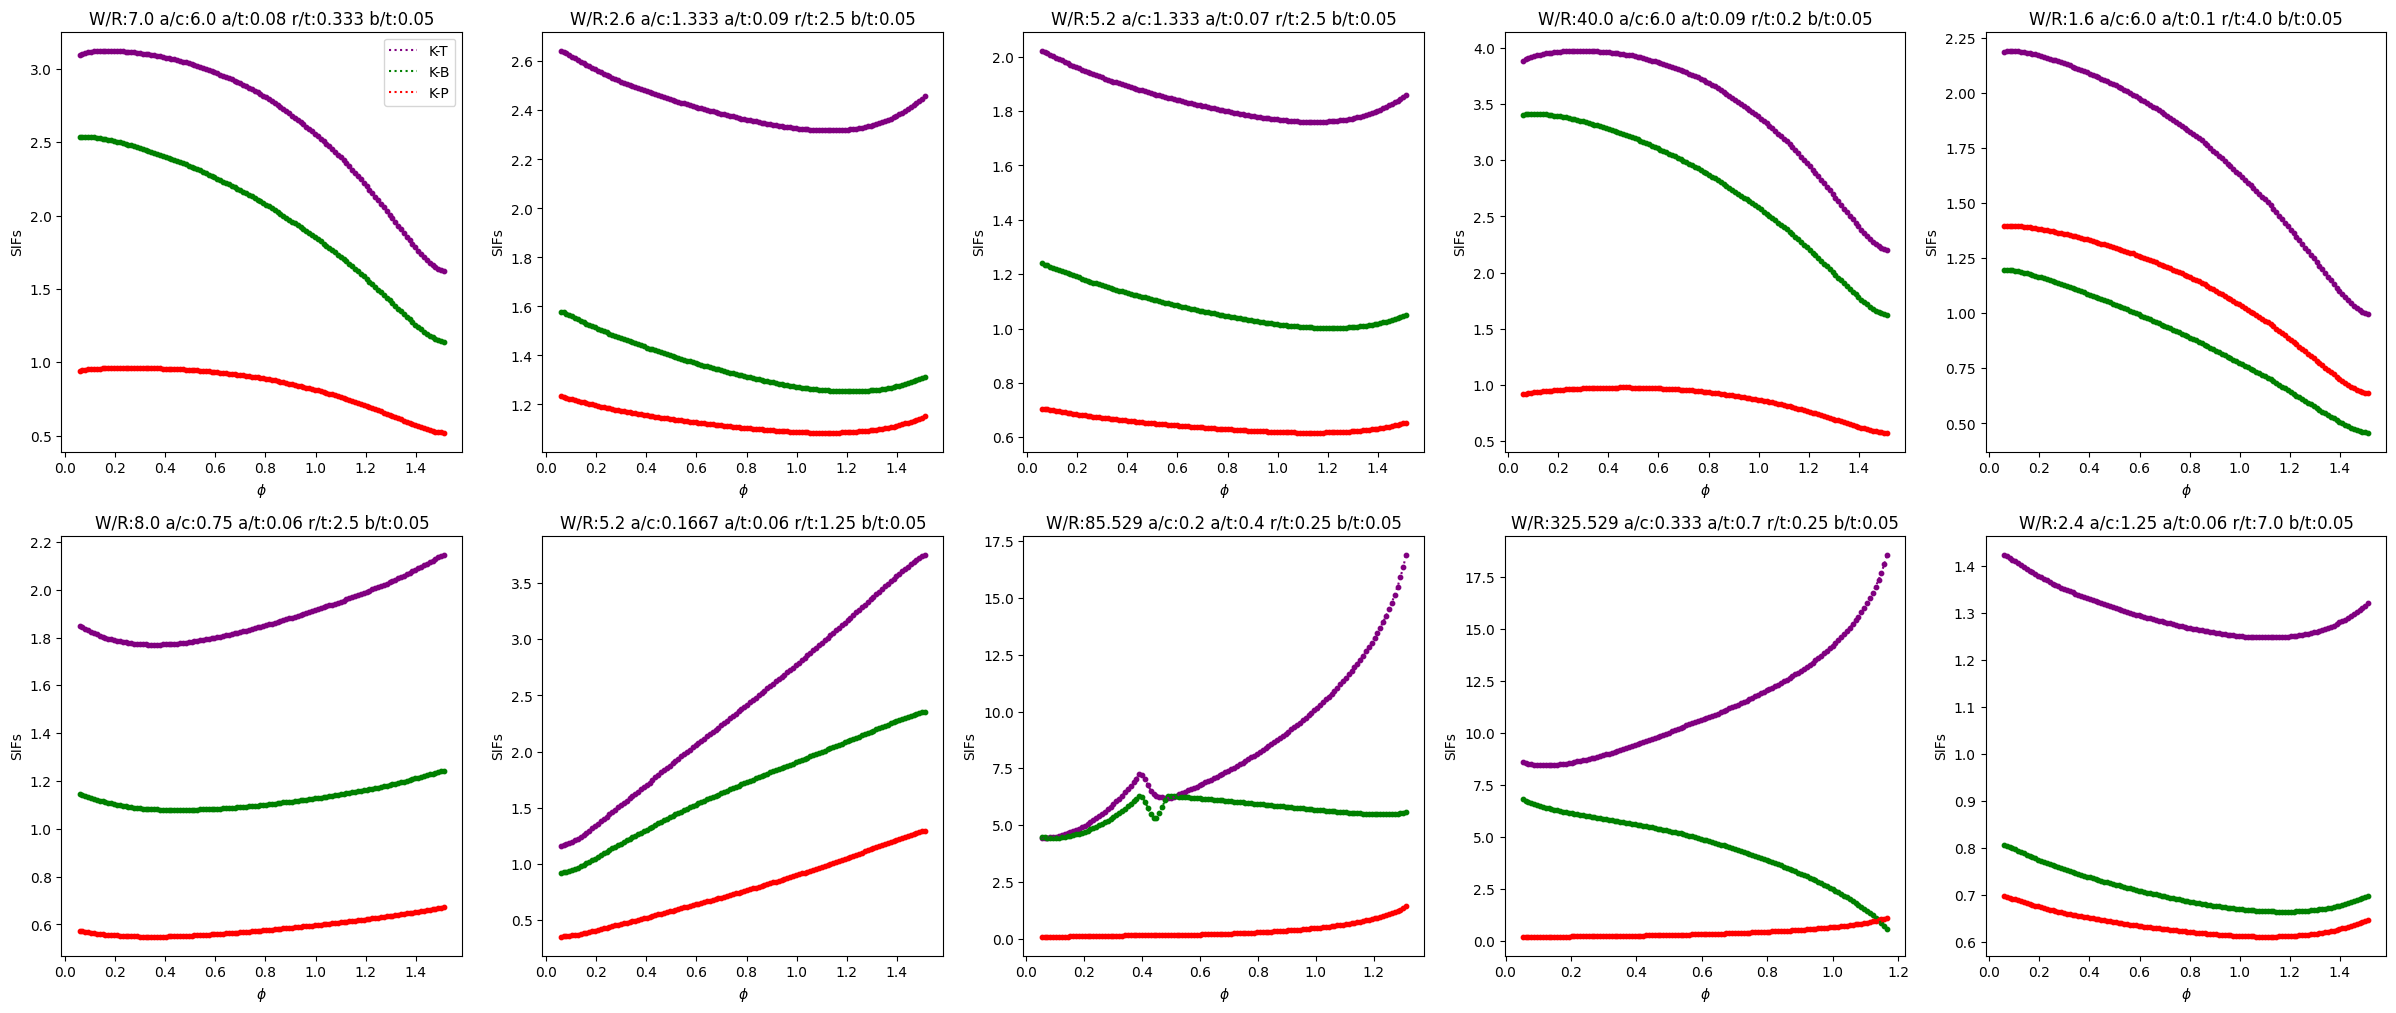

In [9]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

print("Total cracks: ", len(num_crack))

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a_c = np.unique(data[:,2])
        a_t = np.unique(data[:,3])
        r_t = np.unique(data[:,4])
        b_t = np.unique(data[:,5])

        assert len(W_R) == 1
        assert len(a_c) == 1
        assert len(a_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-4], data[:,-3], color='purple', s=10)
        axs[i,j].plot(data[:,-4], data[:,-3], label="K-T", color='purple', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-2], color='green', s=10)
        axs[i,j].plot(data[:,-4], data[:,-2], label="K-B", color='green', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-1], color='red', s=10)
        axs[i,j].plot(data[:,-4], data[:,-1], label="K-P", color='red', linestyle=":")

        axs[i,j].set_title("W/R:{} a/c:{} a/t:{} r/t:{} b/t:{}".format(W_R[0], a_c[0], a_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [36]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:4])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

CC_phi_regular_64 = np.linspace(0.052, 1.52, 64)
CC_K_regular_64 = np.zeros((len(CC_combinations), len(CC_phi_regular_64)))

valid_combs = []
for i, combination in enumerate(CC_combinations):
    comb_tuple = tuple(combination)
    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, 4]
    K_vals = d[indices][:, 5]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,4]
    K_vals = d[filtered_indices][:,5]
    phi_idxes = np.argsort(phi_vals)

    if len(phi_idxes) >= 16:
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]
        
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

        # Interpolate as usual
        interpolated = interp_func(CC_phi_regular_64)
        # Set to zero where phi > phi_max
        interpolated[CC_phi_regular_64 > phi_max] = 0.0
        CC_K_regular_64[i, :] = interpolated

        valid_combs.append(i)

In [37]:
CC_combinations = CC_combinations[valid_combs]
CC_K_regular_64 = CC_K_regular_64[valid_combs]

CC_combinations.shape, CC_K_regular_64.shape

((78178, 4), (78178, 64))

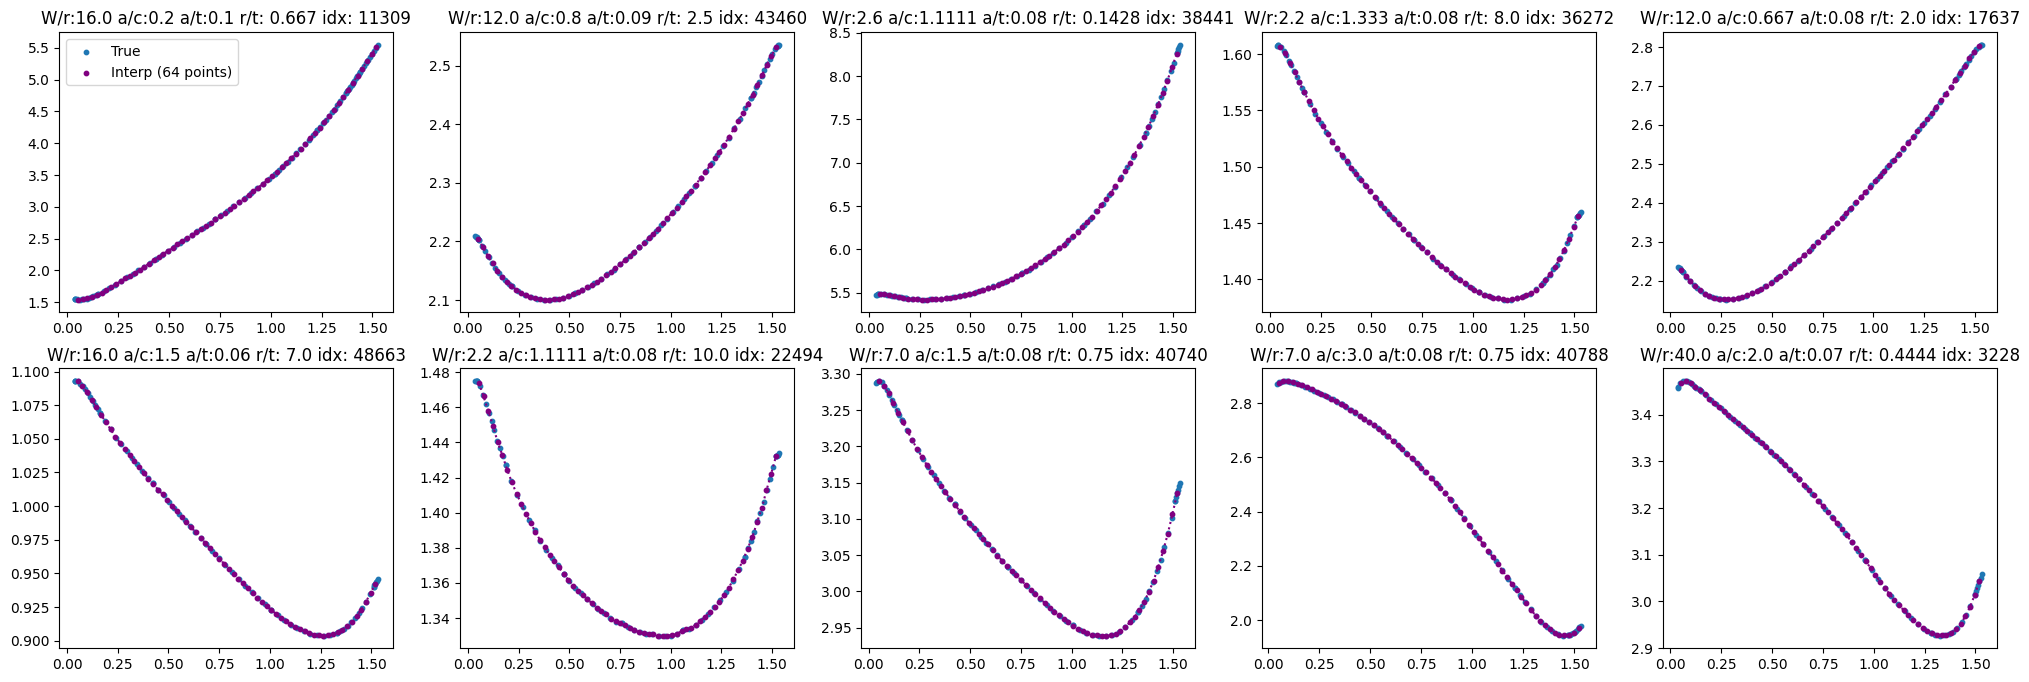

In [41]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(25,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(CC_combinations))
        combination = CC_combinations[idx]
        indices = np.where((d[:, 0] == combination[0]) & 
                        (d[:, 1] == combination[1]) &
                        (d[:, 2] == combination[2]) &
                        (d[:, 3] == combination[3]))
        indices = indices[0]
        phi_vals = d[indices][:, 4]
        K_vals = d[indices][:, 5]

        phi_min = phi_vals.min() + 0.035
        phi_max = phi_vals.max() - 0.035

        # Filter indices where phi values lie within [phi_min, phi_max]
        filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

        axs[i,j].scatter(d[filtered_indices][:,4], d[filtered_indices][:,5], label="True", s=10)
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64[idx], label="Interp (64 points)", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64[idx], color='purple', linestyle=":")
        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {} idx: {}".format(combination[0], combination[1], combination[2], combination[3], idx))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()